# Bayesian regression analysis in lmfit
In this example we will perform a Bayesian regression analysis in the `lmfit` package. You'll need the `emcee` and `corner` packages installed. Both of these are available on PyPI. We start off with the requisite imports.

In [1]:
%matplotlib inline
import numpy as np
import lmfit
import matplotlib.pyplot as plt

Now lets create the data we'll then fit.

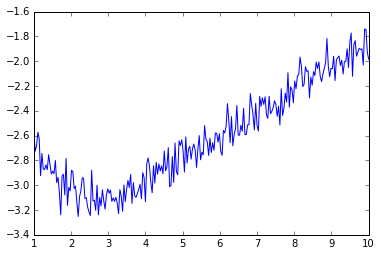

In [2]:
x = np.linspace(1, 10, 250)
np.random.seed(0)
y = 3.0 * np.exp(-x / 2) - 5.0 * np.exp(-(x - 0.1) / 10.) + 0.1 * np.random.randn(len(x))
plt.plot(x, y)
plt.show()

We'll need a `Parameters` object to store the Parameters of our model.

In [3]:
p = lmfit.Parameters()
p.add_many(('a1', 4.), ('a2', 4.), ('t1', 3.), ('t2', 3., True))

def residual(p):
    v = p.valuesdict()
    return v['a1'] * np.exp(-x / v['t1']) + v['a2'] * np.exp(-(x - 0.1) / v['t2']) - y

We'll do a straightforward least-squares fit first, using the *Nelder-Mead* method.

[[Variables]]
    a1:   2.98623688 (init= 4)
    a2:  -4.33525596 (init= 4)
    t1:   1.30993185 (init= 3)
    t2:   11.8240752 (init= 3)
[[Correlations]] (unreported correlations are <  0.500)


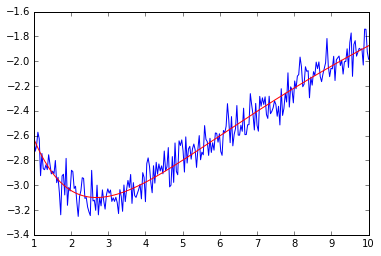

In [4]:
mi = lmfit.minimize(residual, p, method='Nelder')
lmfit.printfuncs.report_fit(mi.params, min_correl=0.5)
plt.plot(x, y)
plt.plot(x, residual(mi.params) + y, 'r')
plt.show()

The above analysis ignored the uncertainty on each datapoint. So we'll add in a noise Parameter to address that. 

In [5]:
# add a noise parameter
mi.params.add('f', value=1, min=0.001, max=2)

For the Bayesian analysis we have to calculate the log-posterior probability for the system. The log-posterior probability is the sum of the log-prior and log-likelihood probabilities. 

The log-prior encodes prior beliefs about the system. With the `lmfit.emcee` method the log-prior probability is assumed to be 0 if a `Parameter` is within its bounds. If it's outside the bounds the log-prior probability is `-np.inf`, i.e. impossible. This is known as a uniform prior.

The log-likelihood function is the probability of the data given the model. The following function calculates the log-likelihood. Note how the [data uncertainties (http://dan.iel.fm/emcee/current/user/line/) are included in the log-likelihood.

Note, if you want a non-uniform prior, then you should include the log-prior and log-likelihood in a single function.

In [6]:
# This is the log-likelihood probability for the sampling. We're going to estimate the
# size of the uncertainties on the data as well.
def lnprob(p):
    resid = residual(p)
    s = p['f']
    c = np.log(2 * np.pi * s**2)
    resid *= 1 / s
    resid *= resid
    resid += c
    return -0.5 * np.sum(resid)

With `lmfit.emcee` we first have to create a `lmfit.Minimizer` object. We're going to initialise it with the best fit from above.

Then we do the sampling. We are going to burn in (discard) the first 300 steps out of a total of 1000. We are then going to thin, which reduces the amount of autocorrelation in the chain. Thinning by 20 means that 1 in 20 samples is kept.

In [7]:
mini = lmfit.Minimizer(lnprob, mi.params)
res = mini.emcee(burn=300, steps=1000, thin=20, params=mi.params)

Now lets plot the outcome with the `corner` package. Note the banana shapes for a2/t1, a2/t2, t1/t2. This indicates a high degree of correlation for these parameter pairs.

/Users/anz/miniconda3/envs/dev3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/anz/miniconda3/envs/dev3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


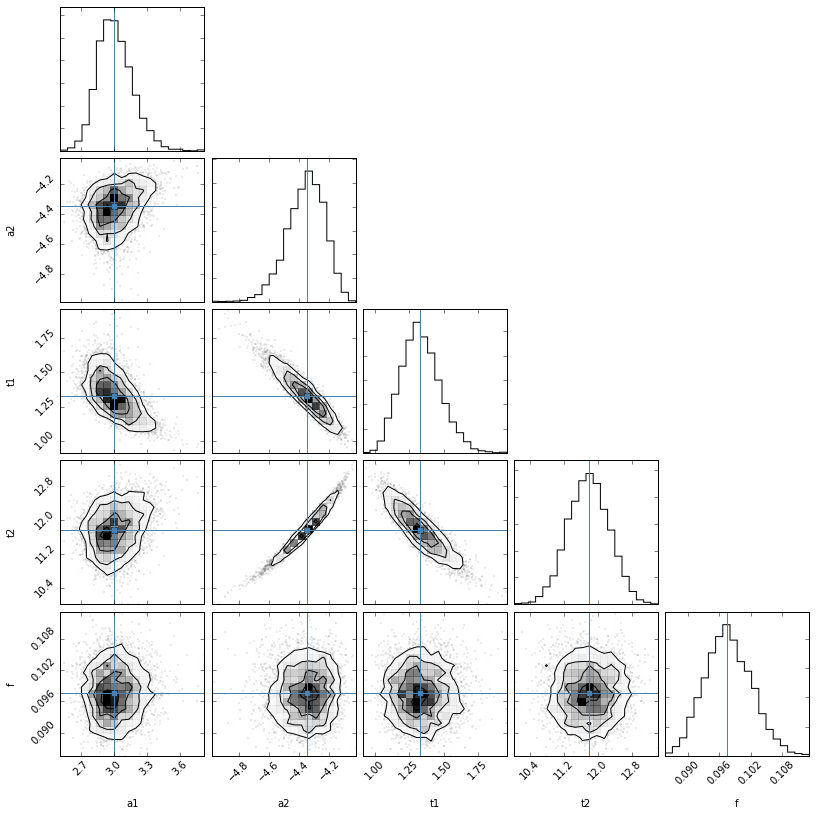

In [8]:
import corner
a=corner.corner(res.flatchain, labels=res.var_names, truths=list(res.params.valuesdict().values()))

Here are the output parameters, the correlations are also worked out. The `OptimizeResult` contains `chain` and `lnprob` attributes which contain the samples and corresponding log-probability. In addition, the Minimizer will then also contain a `sampler` attribute (a `emcee.EnsembleSampler` object) which can be used for other purposes.

In [9]:
print("median of posterior probability distribution")
print('------------------------------------------')
lmfit.report_fit(res.params)
# find the maximum likelihood solution
highest_prob = np.argmax(res.lnprob)
hp_loc = np.unravel_index(highest_prob, res.lnprob.shape)
mle_soln = res.chain[hp_loc]
for i, par in enumerate(p):
    p[par].value = mle_soln[i]
print("\nMaximum likelihood Estimation")
print('-----------------------------')
print(p)

median of posterior probability distribution
------------------------------------------
[[Variables]]
    a1:   2.99885196 +/- 0.155314 (5.18%) (init= 2.986237)
    a2:  -4.34834650 +/- 0.125770 (2.89%) (init=-4.335256)
    t1:   1.32398718 +/- 0.143049 (10.80%) (init= 1.309932)
    t2:   11.7696205 +/- 0.489399 (4.16%) (init= 11.82408)
    f:    0.09750414 +/- 0.004534 (4.65%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(a2, t2)                    =  0.981 
    C(a2, t1)                    = -0.934 
    C(t1, t2)                    = -0.888 
    C(a1, t1)                    = -0.585 
    C(a1, a2)                    =  0.296 
    C(a1, t2)                    =  0.252 

Maximum likelihood Estimation
-----------------------------
Parameters([('a1', <Parameter 'a1', 2.9988423426298825, bounds=[-inf:inf]>), ('a2', <Parameter 'a2', -4.3170930832689391, bounds=[-inf:inf]>), ('t1', <Parameter 't1', 1.2891721649086882, bounds=[-inf:inf]>), ('t2', <Parameter 't2', 11

Finally, let's calculate some uncertainty intervals.

In [10]:
quantiles = np.percentile(res.flatchain['t1'], [2.28, 15.9, 50, 84.2, 97.7])
print("2 sigma spread", 0.5 * (quantiles[-1] - quantiles[0]))

2 sigma spread 0.287019527744
